# Importing packages

In [29]:
import numpy as np
import mirdata
import matplotlib.pyplot as plt

# Undersanding the MDB data

In [2]:
dataset = mirdata.initialize("mdb_stem_synth")

### Local analysis

In [5]:
track_id = dataset.track_ids[0]
track = dataset.track(track_id)

In [13]:
audio, sr = track.audio 

In [27]:
track.f0.frequencies

array([0., 0., 0., ..., 0., 0., 0.], shape=(59067,))

In [26]:
track.f0.voicing

array([0., 0., 0., ..., 0., 0., 0.], shape=(59067,))

In [30]:
audio, sr = track.audio  # audio: (n_samples,)
f0 = track.f0.frequencies        # (n_frames,)
times = track.f0.times           # (n_frames,)

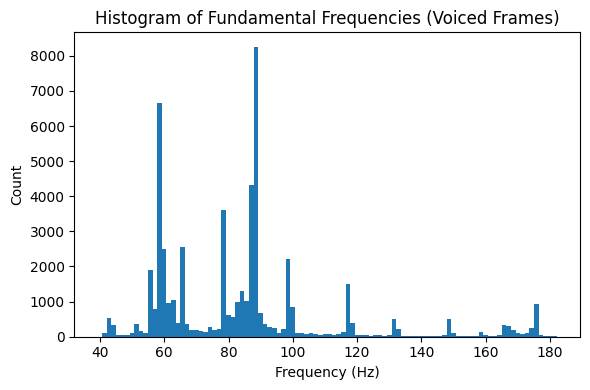

In [31]:
f0_voiced = f0[f0 > 0]

plt.figure(figsize=(6, 4))
plt.hist(f0_voiced, bins=100)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count")
plt.title("Histogram of Fundamental Frequencies (Voiced Frames)")
plt.tight_layout()
plt.show()

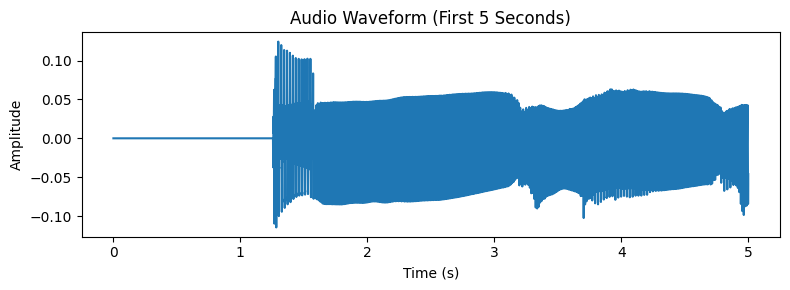

In [33]:
duration = 5.0  # seconds
n_samples = int(duration * sr)

t_audio = np.arange(n_samples) / sr

plt.figure(figsize=(8, 3))
plt.plot(t_audio, audio[:n_samples])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform (First 5 Seconds)")
plt.tight_layout()
plt.show()


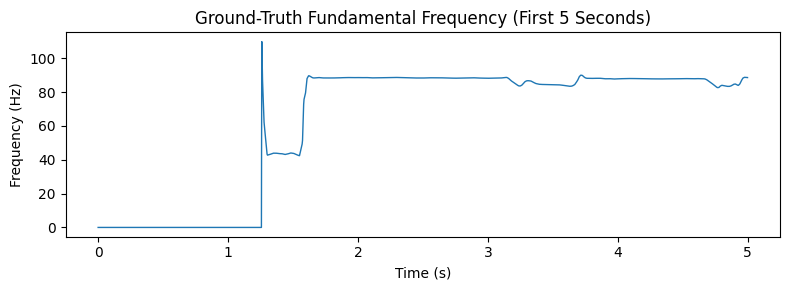

In [42]:
f0 = track.f0.frequencies      # (n_frames,)
t_f0 = track.f0.times          # (n_frames,)


duration = 5.0
mask = t_f0 <= duration

plt.figure(figsize=(8, 3))
plt.plot(t_f0[mask], f0[mask], linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Ground-Truth Fundamental Frequency (First 5 Seconds)")
plt.tight_layout()
plt.show()


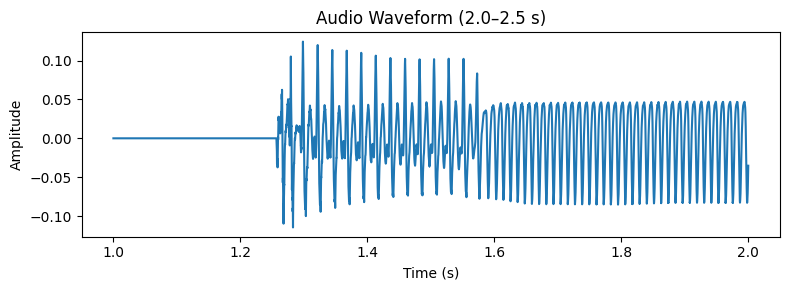

In [37]:
t_start = 1
t_end = 2

i_start = int(t_start * sr)
i_end = int(t_end * sr)

t_zoom = np.arange(i_end - i_start) / sr + t_start

plt.figure(figsize=(8, 3))
plt.plot(t_zoom, audio[i_start:i_end])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform (2.0–2.5 s)")
plt.tight_layout()
plt.show()


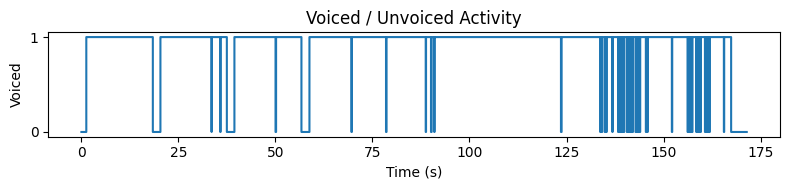

In [34]:
voiced = (f0 > 0).astype(int)

plt.figure(figsize=(8, 2))
plt.step(times, voiced, where="post")
plt.xlabel("Time (s)")
plt.ylabel("Voiced")
plt.yticks([0, 1])
plt.title("Voiced / Unvoiced Activity")
plt.tight_layout()
plt.show()


In [38]:
# testing for auto-correlation
import numpy as np
import matplotlib.pyplot as plt

# # audio: 1D np.array, sr: int

# window/hop (keep it simple and fast)
win_ms = 40.0
hop_ms = 10.0
win = int(sr * win_ms / 1000.0)
hop = int(sr * hop_ms / 1000.0)

# plausible F0 range (Hz) -> lag range (samples)
fmin = 50.0
fmax = 1000.0
lag_min = int(sr / fmax)
lag_max = int(sr / fmin)

# number of frames
n = len(audio)
n_frames = 1 + (n - win) // hop
assert n_frames > 0

periodicity = np.zeros(n_frames, dtype=float)
f0_acf = np.zeros(n_frames, dtype=float)
times_acf = (np.arange(n_frames) * hop + win / 2) / sr

eps = 1e-12

for i in range(n_frames):
    s = i * hop
    x = audio[s:s+win].astype(float)

    # remove DC + apply simple window to stabilise ACF
    x = x - x.mean()
    x = x * np.hanning(win)

    # autocorrelation via FFT (fast)
    X = np.fft.rfft(x, n=2*win)
    r = np.fft.irfft(X * np.conj(X))[:win]

    # normalise by zero-lag energy
    r0 = r[0] + eps
    r = r / r0

    # search peak in lag range
    lo = lag_min
    hi = min(lag_max, win-1)
    if hi <= lo + 1:
        periodicity[i] = 0.0
        f0_acf[i] = 0.0
        continue

    k = lo + np.argmax(r[lo:hi])
    peak = r[k]

    periodicity[i] = float(peak)
    f0_acf[i] = float(sr / k) if peak > 0 else 0.0


In [39]:
# thresholds you can tune quickly
per_drop = 0.25           # periodicity drop threshold
f0_jump_semitones = 2.0   # pitch jump threshold (in semitones)

# periodicity ruptures: big negative first difference
dper = np.diff(periodicity, prepend=periodicity[0])
rupt_per = dper < -per_drop

# pitch ruptures: compute jump in semitones, ignore low periodicity frames
f0_safe = np.where(periodicity > 0.3, f0_acf, np.nan)
midi = 69 + 12 * np.log2(f0_safe / 440.0)

dmidi = np.abs(np.diff(midi, prepend=midi[0]))
rupt_f0 = dmidi > f0_jump_semitones

rupt = rupt_per | rupt_f0


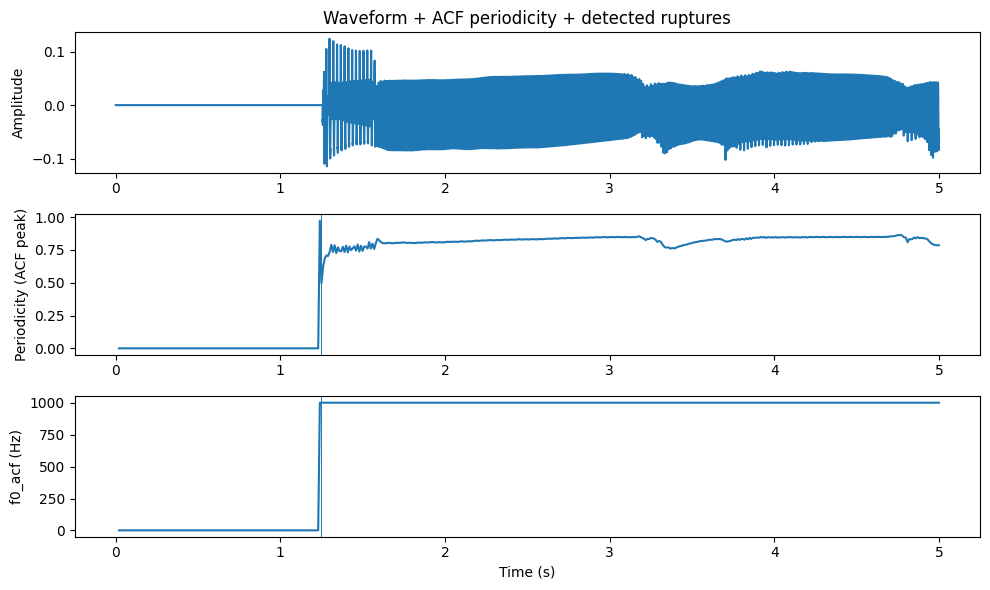

In [40]:
# plot a short excerpt for readability
t0, t1 = 0.0, 5.0
i0, i1 = int(t0 * sr), int(t1 * sr)

plt.figure(figsize=(10, 6))

# waveform
ax1 = plt.subplot(3, 1, 1)
tt = np.arange(i1 - i0) / sr + t0
ax1.plot(tt, audio[i0:i1])
ax1.set_ylabel("Amplitude")
ax1.set_title("Waveform + ACF periodicity + detected ruptures")

# periodicity
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
mask = (times_acf >= t0) & (times_acf <= t1)
ax2.plot(times_acf[mask], periodicity[mask])
ax2.set_ylabel("Periodicity (ACF peak)")

# f0 proxy
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(times_acf[mask], f0_acf[mask])
ax3.set_ylabel("f0_acf (Hz)")
ax3.set_xlabel("Time (s)")

# rupture markers on periodicity plot (clean visual)
r_times = times_acf[rupt & mask]
for t in r_times:
    ax2.axvline(t, linewidth=0.7)
    ax3.axvline(t, linewidth=0.7)

plt.tight_layout()
plt.show()


### Global analysis

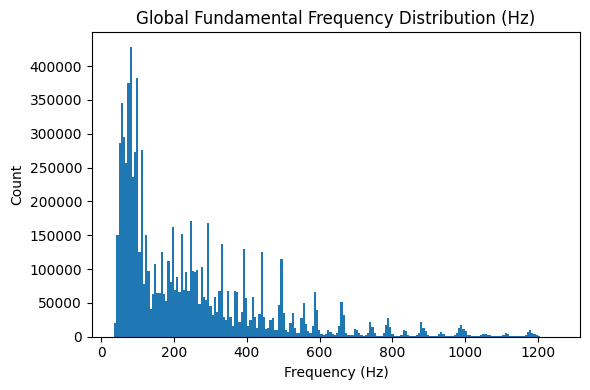

In [44]:
# Distribution of the (voiced) f_0 frequencies
track_ids = dataset.track_ids

all_f0 = []

for tid in track_ids:
    track = dataset.track(tid)
    f0 = track.f0.frequencies
    all_f0.append(f0[f0 > 0])

all_f0 = np.concatenate(all_f0)

plt.figure(figsize=(6, 4))
plt.hist(all_f0, bins=200)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count")
plt.title("Global Fundamental Frequency Distribution (Hz)")
plt.tight_layout()
plt.show()


In [45]:
print("Frequency range (Hz):")
print("min:", np.min(all_f0))
print("median:", np.median(all_f0))
print("max:", np.max(all_f0))


Frequency range (Hz):
min: 34.96424
median: 176.739086
max: 1254.845215


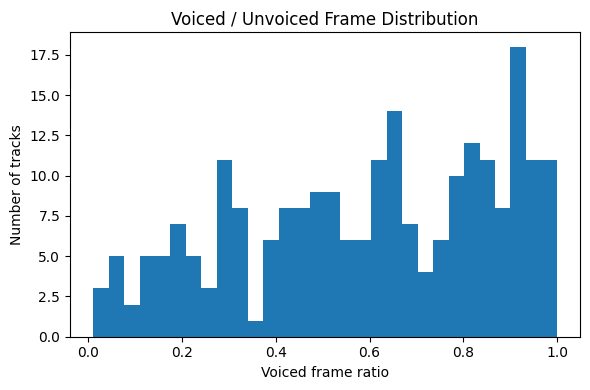

Average voiced ratio: 0.5947366385235351


In [46]:
#preponderance of voiced tracks

voiced_ratios = []

for tid in track_ids:
    track = dataset.track(tid)
    f0 = track.f0.frequencies
    voiced_ratios.append(np.mean(f0 > 0))

voiced_ratios = np.array(voiced_ratios)

plt.figure(figsize=(6, 4))
plt.hist(voiced_ratios, bins=30)
plt.xlabel("Voiced frame ratio")
plt.ylabel("Number of tracks")
plt.title("Voiced / Unvoiced Frame Distribution")
plt.tight_layout()
plt.show()

print("Average voiced ratio:", voiced_ratios.mean())


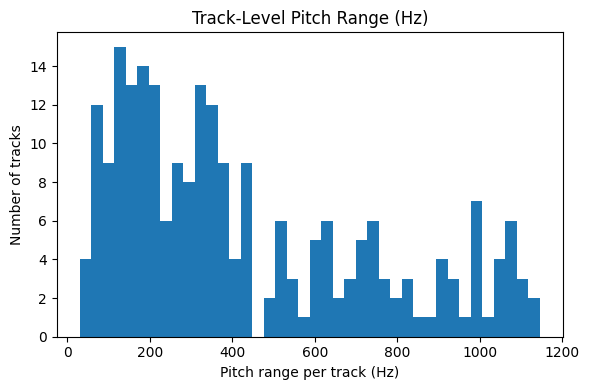

Median pitch range (Hz): 335.87904149999997


In [47]:
# Range of (non-mute) frequencies per track

track_ranges = []

for tid in track_ids:
    track = dataset.track(tid)
    f0 = track.f0.frequencies
    f0 = f0[f0 > 0]
    if len(f0) == 0:
        continue
    track_ranges.append(f0.max() - f0.min())

track_ranges = np.array(track_ranges)

plt.figure(figsize=(6, 4))
plt.hist(track_ranges, bins=40)
plt.xlabel("Pitch range per track (Hz)")
plt.ylabel("Number of tracks")
plt.title("Track-Level Pitch Range (Hz)")
plt.tight_layout()
plt.show()

print("Median pitch range (Hz):", np.median(track_ranges))


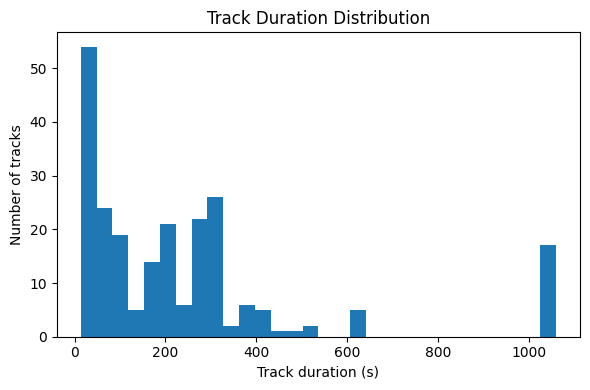

Total duration (hours): 15.564212421264804
Median track duration (s): 181.85034013605443


In [48]:
# average duration of a track:

durations = []

for tid in track_ids:
    track = dataset.track(tid)
    audio, sr = track.audio
    durations.append(len(audio) / sr)

durations = np.array(durations)

plt.figure(figsize=(6, 4))
plt.hist(durations, bins=30)
plt.xlabel("Track duration (s)")
plt.ylabel("Number of tracks")
plt.title("Track Duration Distribution")
plt.tight_layout()
plt.show()

print("Total duration (hours):", durations.sum() / 3600)
print("Median track duration (s):", np.median(durations))


# Understanding the Orchest data

In [49]:
dataset = mirdata.initialize("orchset")

### Local Analysis

In [50]:
track_id = dataset.track_ids[0]
track = dataset.track(track_id)

In [53]:
track.melody.frequencies 

array([  0.   ,   0.   ,   0.   , ..., 391.995, 391.995, 391.995],
      shape=(1247,))

In [55]:
audio, sr = track.audio_mono
audio

array([-0.02606201, -0.02124023, -0.01483154, ..., -0.00161743,
       -0.00042725,  0.00091553], shape=(555186,), dtype=float32)

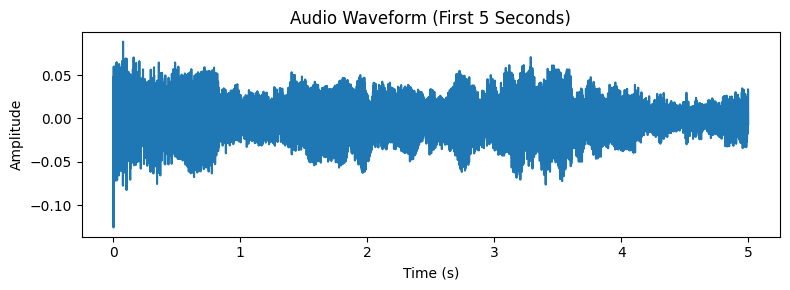

In [56]:
duration = 5.0  # seconds
n_samples = int(duration * sr)

t_audio = np.arange(n_samples) / sr

plt.figure(figsize=(8, 3))
plt.plot(t_audio, audio[:n_samples])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Audio Waveform (First 5 Seconds)")
plt.tight_layout()
plt.show()


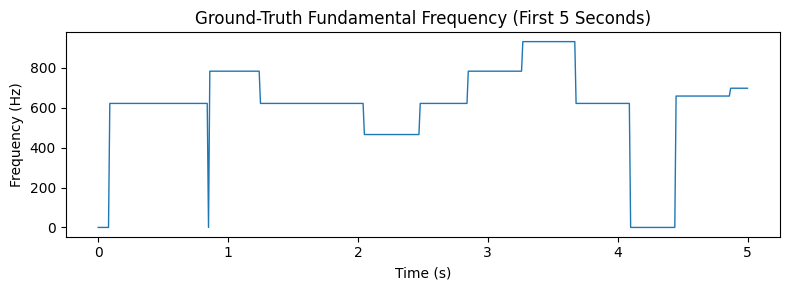

In [58]:
f0 = track.melody.frequencies      # (n_frames,)
t_f0 = track.melody.times          # (n_frames,)


duration = 5.0
mask = t_f0 <= duration

plt.figure(figsize=(8, 3))
plt.plot(t_f0[mask], f0[mask], linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Ground-Truth Fundamental Frequency (First 5 Seconds)")
plt.tight_layout()
plt.show()


### global analysis

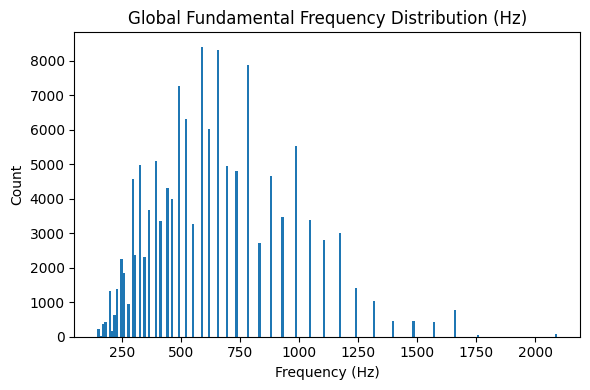

In [60]:
# Distribution of the (voiced) f_0 frequencies
track_ids = dataset.track_ids

all_f0 = []

for tid in track_ids:
    track = dataset.track(tid)
    f0 = track.melody.frequencies
    all_f0.append(f0[f0 > 0])

all_f0 = np.concatenate(all_f0)

plt.figure(figsize=(6, 4))
plt.hist(all_f0, bins=200)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Count")
plt.title("Global Fundamental Frequency Distribution (Hz)")
plt.tight_layout()
plt.show()

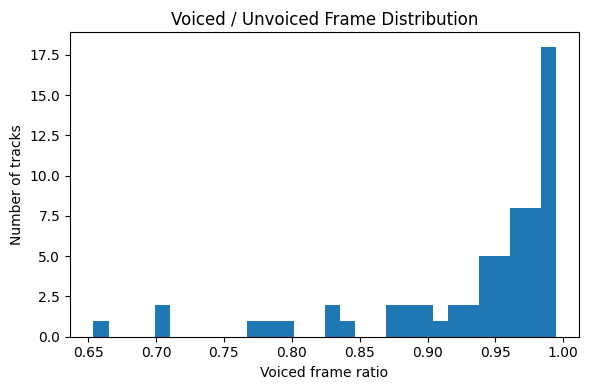

Average voiced ratio: 0.9328023771705578


In [61]:
#preponderance of voiced tracks

voiced_ratios = []

for tid in track_ids:
    track = dataset.track(tid)
    f0 = track.melody.frequencies
    voiced_ratios.append(np.mean(f0 > 0))

voiced_ratios = np.array(voiced_ratios)

plt.figure(figsize=(6, 4))
plt.hist(voiced_ratios, bins=30)
plt.xlabel("Voiced frame ratio")
plt.ylabel("Number of tracks")
plt.title("Voiced / Unvoiced Frame Distribution")
plt.tight_layout()
plt.show()

print("Average voiced ratio:", voiced_ratios.mean())


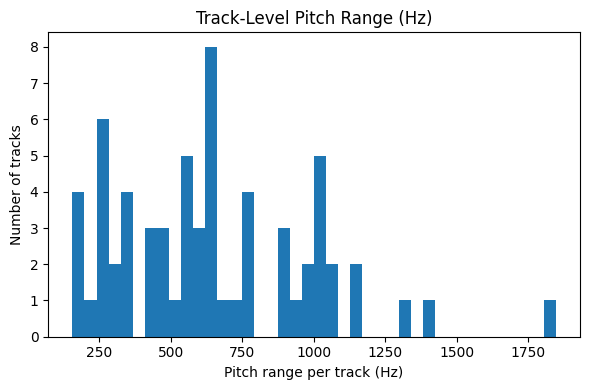

Median pitch range (Hz): 623.021


In [62]:
# Range of (non-mute) frequencies per track

track_ranges = []

for tid in track_ids:
    track = dataset.track(tid)
    f0 = track.melody.frequencies
    f0 = f0[f0 > 0]
    if len(f0) == 0:
        continue
    track_ranges.append(f0.max() - f0.min())

track_ranges = np.array(track_ranges)

plt.figure(figsize=(6, 4))
plt.hist(track_ranges, bins=40)
plt.xlabel("Pitch range per track (Hz)")
plt.ylabel("Number of tracks")
plt.title("Track-Level Pitch Range (Hz)")
plt.tight_layout()
plt.show()

print("Median pitch range (Hz):", np.median(track_ranges))


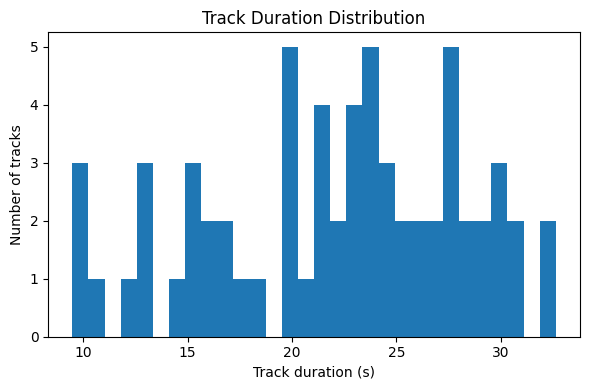

Total duration (hours): 0.3925160241874528
Median track duration (s): 22.74062358276644


In [63]:
# average duration of a track:

durations = []

for tid in track_ids:
    track = dataset.track(tid)
    audio, sr = track.audio_mono
    durations.append(len(audio) / sr)

durations = np.array(durations)

plt.figure(figsize=(6, 4))
plt.hist(durations, bins=30)
plt.xlabel("Track duration (s)")
plt.ylabel("Number of tracks")
plt.title("Track Duration Distribution")
plt.tight_layout()
plt.show()

print("Total duration (hours):", durations.sum() / 3600)
print("Median track duration (s):", np.median(durations))
